In [1]:
import os
import sys
sys.path.insert(0, '..')

import argparse
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from utils import *
from model.metric import evaluate, acc, LSR
from model.data import DAdataset
from model.net import LSTMClassifier
from model.utils import sent_tokenize, stemming, preprocess_text
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
home_dir = Path('..')
data_dir = home_dir / 'dataset' / 'SDAC'
save_dir = home_dir / 'experiment' / 'SDAC'
train_data_name = 'sw_train.txt'
valid_data_name = 'sw_val.txt'
test_data_name = 'sw_test.txt'
# pretrained_embeddings_name = 'embeddings.pkl'
token2idx_name = 'word2idx.json'
label2idx_name = 'label2idx.json'
config_name = 'config.json'
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

In [3]:
args = {
    "epochs": 50,
    "n_batch": 64,
    # "max_len": 256,
    "lr": 1e-5,
    "summary_step": 10000,
    "embedding_dim": 512,
    "hidden_size": 512,
    "n_layers": 2,
}
args = argparse.Namespace(**args)
print(args)

Namespace(embedding_dim=512, epochs=50, hidden_size=512, lr=1e-05, n_batch=64, n_layers=2, summary_step=10000)


In [4]:
# with open(data_dir / pretrained_embeddings_name, 'rb') as f:
#     pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)
    
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

## Train

In [5]:
# 데이터 전처리 

train_data = pd.read_csv(data_dir / train_data_name, header=None, sep='|', names=['speaker','utterance','tag'])
valid_data = pd.read_csv(data_dir / valid_data_name, header=None, sep='|', names=['speaker','utterance','tag'])


x_train, y_train = train_data['utterance'], train_data['tag']
x_valid, y_valid = valid_data['utterance'], valid_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming] # 이전에 해줬던 전처리 과정과 동일하게 해줘야 함

x_train = x_train.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)
x_valid = x_valid.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

In [6]:
# 학습 데이터 구성

x_train = list(convert_token_to_idx(x_train, token2idx))
x_valid = list(convert_token_to_idx(x_valid, token2idx))

y_train = list(convert_label_to_idx(y_train, label2idx))
y_valid = list(convert_label_to_idx(y_valid, label2idx))

tr_ds = DAdataset(x_train, y_train)
tr_dl = DataLoader(tr_ds, batch_size=args.n_batch, collate_fn=tr_ds.collate_fn, shuffle=True, drop_last=True)

val_ds = DAdataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=args.n_batch, collate_fn=val_ds.collate_fn, shuffle=True, drop_last=True)

In [7]:
# 모델 생성

learning_rate = args.lr
batch_size = args.n_batch
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)
n_layers = args.n_layers
dropout = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(output_size, hidden_size, vocab_size, n_layers, embedding_dim, device,
                       dropout=dropout, bidirectional=True) #, weights=torch.from_numpy(pretrained_embeddings))

loss_fn = LSR(epsilon=0.1, num_classes=output_size)

if device.type == 'cuda':
    torch.cuda.empty_cache()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

writer = SummaryWriter(f'{save_dir}/runs')
checkpoint_manager = CheckpointManager(save_dir)
summary_manager = SummaryManager(save_dir)

In [ ]:
# 모델 학습

best_val_loss = 1e+10
train_acc = []
valid_acc = []
train_losses = []
valid_losses = []
# x_error_check = []  # Issue 에 대한 디버깅 코드

for epoch in tqdm(range(args.epochs), desc='epochs'):
    tr_loss = 0
    tr_acc = 0
    model.train()
    
    for step, mb in tqdm(enumerate(tr_dl), desc='steps', total=len(tr_dl)):
        x_mb, y_mb = map(lambda elm: elm.to(device), mb)
        
#         x_error_check.append(x_mb)
#         if len(x_error_check) > 2:
#             del x_error_check[0]
        
        optimizer.zero_grad()
        y_hat_mb = model(x_mb)
        loss = loss_fn(y_hat_mb, y_mb)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            mb_acc = acc(y_hat_mb, y_mb)
        
        clip_gradient(model, 1e-1)
        
        tr_loss += loss.item()
        tr_acc += mb_acc.item()
        
        if (epoch*len(tr_dl)+step) % args.summary_step == 0:
            val_loss = evaluate(model, val_dl, {'loss':loss_fn}, device)['loss']
            writer.add_scalars('loss', {'train': tr_loss / (step + 1), 'val': val_loss}, epoch*len(tr_dl) + step)
            tqdm.write('global_Step: {:3}, tr_loss: {:3f}, val_loss: {:3f}'.format(epoch* len(tr_dl) + step,
                                                                                       tr_loss / (step + 1),
                                                                                       val_loss))
            model.train()
    
    else:
        tr_loss  /= (step + 1)
        tr_acc /= (step + 1)
        train_losses.append(tr_loss)
        train_acc.append(tr_acc)
        
        tr_sum = {'loss': tr_loss, 'acc': tr_acc}
        val_sum = evaluate(model, val_dl, {'loss': loss_fn, 'acc': acc}, device)
        tqdm.write('epoch : {}, tr_loss: {: 3f}, val_loss: '
                       '{:.3f}, tr_acc: {:.2%}, val_acc: {:.2%}'.format(epoch+1, tr_sum['loss'], val_sum['loss'],
                                                                        tr_sum['acc'], val_sum['acc']))
        
        val_loss = val_sum['loss']
        valid_losses.append(val_loss)
        valid_acc.append(val_sum['acc'])
        is_best = val_loss < best_val_loss
        
        if is_best:
            state = {
                'epoch': epoch+1, 
                'model_state_dict': model.state_dict(), 
                'opt_state_dict': optimizer.state_dict()
            }
            summary = {'tr': tr_sum, 'val': val_sum}
            summary_manager.update(summary)
            summary_manager.save('summary.json')
            checkpoint_manager.save_checkpoint(state, 'best.tar')
            best_val_loss = val_loss

steps: 100%|██████████| 51/51 [00:00<00:00, 101.61it/s]


global_Step:   0, tr_loss: 1.249991, val_loss: 1.240082


steps:  41%|████      | 21/51 [00:00<00:00, 100.24it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 101.08it/s]


epoch : 1, tr_loss:  0.724955, val_loss: 0.586, tr_acc: 52.82%, val_acc: 60.73%


steps:  22%|██▏       | 11/51 [00:00<00:00, 102.80it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 101.49it/s]


epoch : 2, tr_loss:  0.601390, val_loss: 0.559, tr_acc: 61.26%, val_acc: 63.72%


steps:  20%|█▉        | 10/51 [00:00<00:00, 91.74it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 102.32it/s]


epoch : 3, tr_loss:  0.568473, val_loss: 0.520, tr_acc: 64.06%, val_acc: 66.41%


steps: 100%|██████████| 51/51 [00:00<00:00, 103.35it/s]


global_Step: 10000, tr_loss: 0.552915, val_loss: 0.512224


steps:  24%|██▎       | 12/51 [00:00<00:00, 110.76it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 102.13it/s]


epoch : 4, tr_loss:  0.548360, val_loss: 0.501, tr_acc: 65.39%, val_acc: 67.27%


steps:  22%|██▏       | 11/51 [00:00<00:00, 101.85it/s]

steps: 100%|██████████| 51/51 [00:00<00:00, 100.12it/s]


epoch : 5, tr_loss:  0.533237, val_loss: 0.494, tr_acc: 66.42%, val_acc: 68.49%


    1. jupyter notebook 버전이 다르면 tqdm이 안예쁘게 나올 수 있음
    2. gpu를 안쓸경우 생각보다 오래 걸림

    Issue) 갑자기 아래의 에러가 나는 경우
    
    (Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.FloatTensor instead 
     while checking arguments for embedding)
    
    tr_dl 에서 나오는 index가 갑자기 소수점으로 바뀌는 경우가 있음. 
    위 에러가 뜬 뒤, x_mb.dtype 을 확인해보면 데이터 타입이 torch.float32 로 바뀌어 있음.
    아마, batch 의 첫 번째 row가 empty일때, 이를 빼고 배치를 계산한뒤 다시 복구시킬때 gpu 에서 소수점으로 반환하는듯 
    (torch gpu 초기값 문제일수도 있음)
    
    해결) 데이터 전처리시, punctuation 을 제거하지 않음. 문장중에 . 혹은 ? 만 있는 문장이 있기 때문에 empty sentence가 생김

In [9]:
summary

{'tr': {'loss': 0.3986261745174964, 'acc': 0.750935628742515},
 'val': {'loss': 0.390417542026212, 'acc': 0.7625305623471883}}

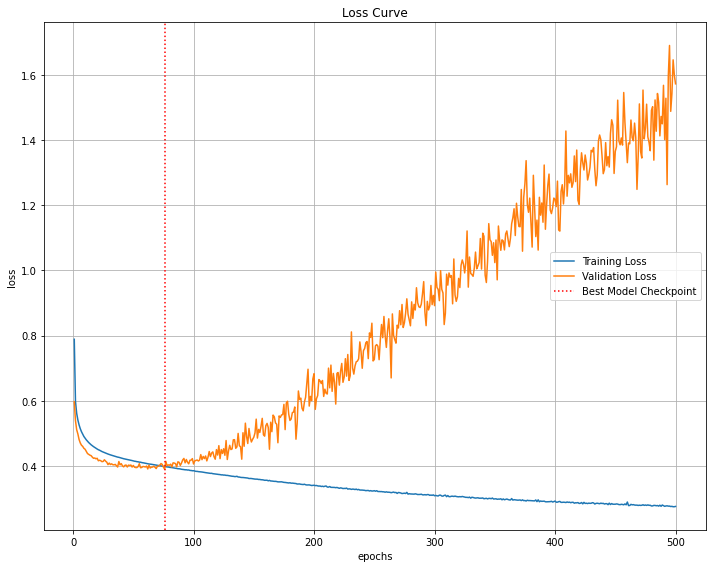

In [10]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='dotted', color='r',label='Best Model Checkpoint')

plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/loss_plot.png', bbox_inches = 'tight')

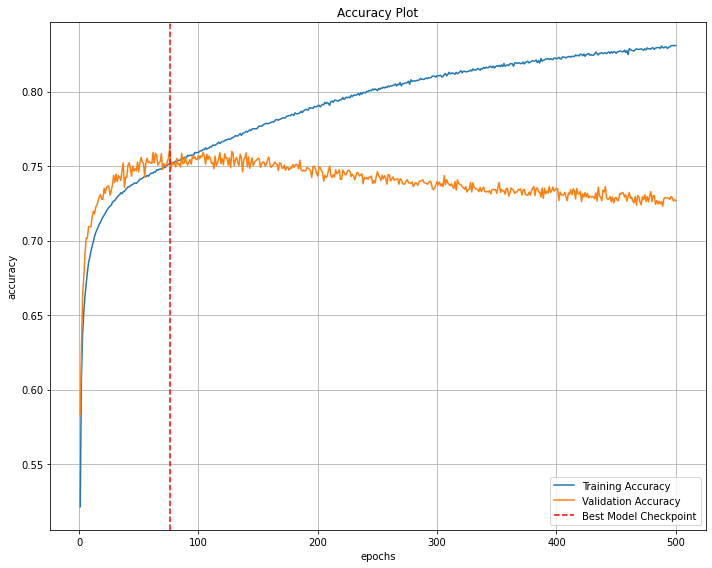

In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1), train_acc, label='Training Accuracy')
plt.plot(range(1,len(valid_acc)+1), valid_acc, label='Validation Accuracy')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Best Model Checkpoint')

plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/accuracy_plot.png', bbox_inches = 'tight')

### Test Label 이 존재할 경우

In [12]:
test_data = pd.read_csv(data_dir / test_data_name, header=None, sep='|', names=['speaker','utterance','tag'])

x_test, y_test = test_data['utterance'], test_data['tag']

text_preprocess_pipeline = [sent_tokenize, stemming]
x_test = x_test.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

x_test = list(convert_token_to_idx(x_test, token2idx))
y_test = list(convert_label_to_idx(y_test, label2idx))

test_ds = DAdataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn, drop_last=True)

In [13]:
summ = evaluate(model, test_dl, {'loss': loss_fn, 'acc': acc}, device)

summary_manager = SummaryManager(save_dir)
summary_manager.load('summary.json')
summary_manager.update(summ)
summary_manager.save('summary.json')

print('loss: {:3f}, acc: {:.2%}'.format(summ['loss'], summ['acc']))

steps: 100%|██████████| 63/63 [00:00<00:00, 257.90it/s]

loss: 0.445932, acc: 70.65%


https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222
https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0
https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html
https://nbviewer.jupyter.org/github/simonjisu/pytorch_tutorials/blob/master/00_Basic_Utils/02_PackedSequence.ipynb

데이터 전처리: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=qbxlvnf11&logNo=221434157182

pretrained 사용: https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222